## Crawl captcha

In [6]:
from time import sleep
import undetected_chromedriver.v2 as uc
from selenium.webdriver.common.by import By
import requests
from io import BytesIO
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Start a headless Chrome browser instance
options = uc.ChromeOptions()
options.headless = False

In [8]:
class CrawlImage():
    def __init__(self, url = "https://sv.iuh.edu.vn/sinh-vien-dang-nhap.html"):
        self.url = url
        self.driver = uc.Chrome(options=options)

    def get_captcha(self):
        # Open the URL
        self.driver.get(self.url)
        sleep(1)
        # Find the image element using XPATH
        element = self.driver.find_element(by = By.XPATH, value = f"//*[@id='newcaptcha']")
        sleep(1)
        # Get the image URL and download the image
        image_url = element.get_attribute('src')
        response = requests.get(image_url)
        # get the image
        image = Image.open(BytesIO(response.content))
        return np.array(image)

    def show(self, image):
        plt.imshow(image)
        plt.title("SIZE: " + str(image.shape))
        plt.show()
    
    def fresher_captcha(self):
        self.driver.find_element(by = By.XPATH, value = '//*[@id="form-login"]/div/div[2]/div[2]/div[1]/a').click()
    
    def save(self, image, name, path):
        image.save(path + name + ".png")
        

In [9]:
crawl = CrawlImage()
image = crawl.get_captcha()
crawl.driver.close()

NameError: name 'self' is not defined

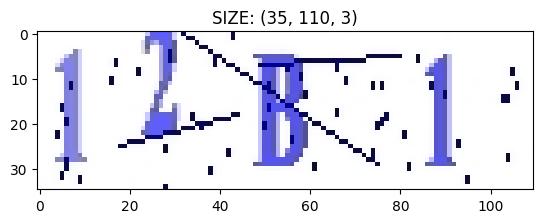

In [10]:
crawl.show(image)

## Processing data

In [14]:
import cv2
import numpy as np
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt

In [15]:
det = []
ope = []
ori = []

def draw(img, cnts):
    img_copy = img.copy()
    # img_copy = cv2.cvtColor(img_copy, cv2.COLOR_GRAY2RGB)
    coordinates = []
    # t = np.mean([get_area(cv2.boundingRect(i)) for i in cnts])
    # t = np.mean([cv2.contourArea(i) for i in cnts])
    for c in cnts:
        if cv2.contourArea(c) > 20:
            x,y,w,h = cv2.boundingRect(c)
            coordinates.append((x, y, w, h))
            cv2.rectangle(img_copy,(x,y),(x+w,y+h), (0, 255, 0), 1)
    return img_copy

for i in tqdm(range(60, 70)):
    img = cv2.imread('captcha/' + f'{i}.png')
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray_img, 3)
    threshold = (blur < np.mean(blur)).astype(np.uint8)
    thresh = (gray_img < np.mean(gray_img)).astype(np.uint8)

    kernel1 = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    # kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # er = cv2.erode(thresh, kernel1, iterations=1)
    # di = cv2.dilate(er, kernel2, iterations=1)

    opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel1, iterations=1)
    
    cnts1 = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    cnts2 = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    # vẽ contour
    img_copy1 = draw(img, cnts1)
    img_copy2 = draw(img, cnts2)

    ope.append(img_copy2)
    det.append(img_copy1)
    ori.append(gray_img)


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


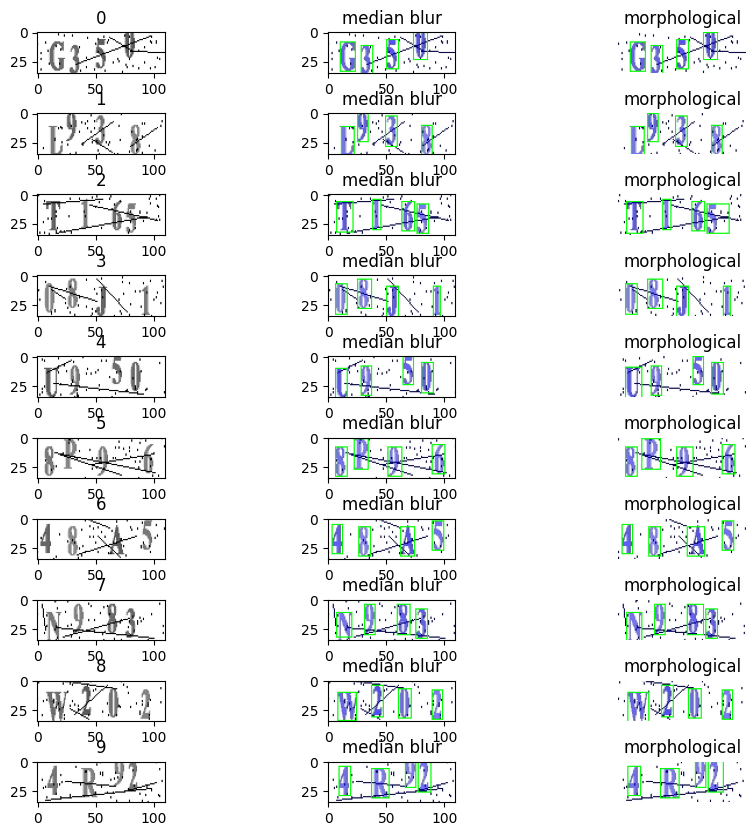

In [16]:
%matplotlib inline
n = 10
fig, axes = plt.subplots(n, 3, figsize=(10, 10))
for i in range(n):
    r = i % n
    
    axes[r, 0].imshow(ori[i], cmap='gray')
    axes[r, 1].imshow(ope[i][:,:,::-1])
    axes[r, 2].imshow(det[i][:,:,::-1])

    axes[r, 0].set_title(f'{i}')
    axes[r, 2].set_title(f'morphological')
    axes[r, 1].set_title(f'median blur')

    axes[r, 2].axis('off')
plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

In [19]:
class processing():
    def __init__(self):
        pass
    def read_img(self, file_name):
        return cv2.imread(file_name)

    def gray_scale(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    def segmentation(self, gray_img):
        blur = cv2.medianBlur(gray_img, 3)
        threshold = (blur < np.mean(blur)).astype(np.uint8)
        return threshold

    def opening(self, binary_img):
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=1)
        return opening

    def draw_contour(self, file_name):
        img = self.read_img(file_name)
        gray = self.gray_scale(img)
        seg = self.segmentation(gray)
        binary_img = self.opening(seg)
        cnts = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
        img_copy = img.copy()
        coordinates = []
        for c in cnts:
            if cv2.contourArea(c) > 20:
                x,y,w,h = cv2.boundingRect(c)
                coordinates.append((x, y, w, h))
                cv2.rectangle(img_copy,(x,y),(x+w,y+h), 0, 1)
        return coordinates, img_copy
    
    def show_draw(self, file_name):
        draw = self.draw_contour(file_name)[1]
        plt.imshow(draw[:,:,::-1])
        plt.show()
    
    def crop_img(self, file_name):
        img = self.read_img(file_name)
        gray = self.gray_scale(img)
        coors = self.draw_contour(file_name)[0]
        # crops = [gray[y:y+h, x:x+w] for x,y,w,h in coors]
        crops = []
        pad = 10
        for i in coors:
            x, y, w, h = i
            crop = gray[y+pad:y+h+pad, x+pad:x+w+pad]
            crops.append(crop)
        return crops
    
    def show_crop(self, file_name):
        img = self.read_img(file_name)
        gray = self.gray_scale(img)
        crops = self.crop_img(file_name)
        n = len(crops)
        fig, ax = plt.subplots(1, n+1, figsize=(10, 10))
        ax[0].imshow(gray, cmap='gray')
        for i in range(n):
            ax[i+1].imshow(crops[i], cmap='gray')
        plt.subplots_adjust(wspace=1)
        plt.show()


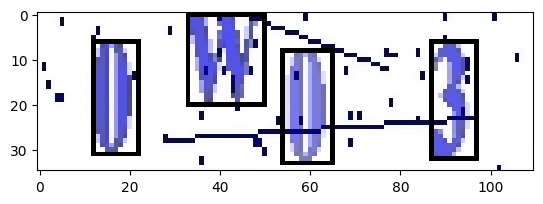

In [20]:
p = processing()
path = 'captcha/' + f'{99}.png'
p.show_draw(path)

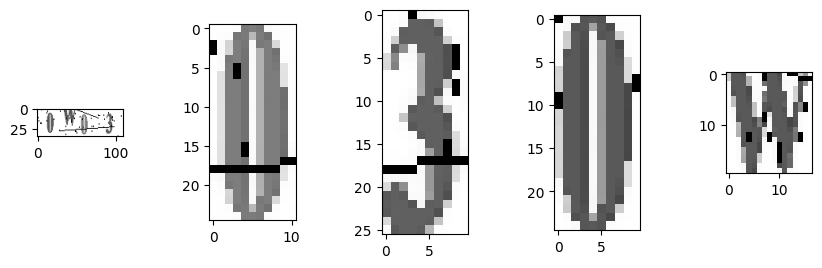

In [19]:
p.show_crop(path)

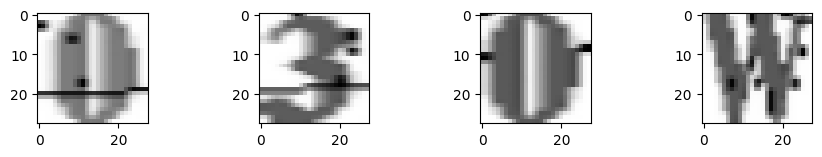

In [20]:
crops = p.crop_img(path)
n = len(crops)
rz = [cv2.resize(i, (28, 28)) for i in crops]
fig, ax = plt.subplots(1, n, figsize=(10, 10))
for i in range(n):
    ax[i].imshow(rz[i], cmap='gray')
plt.subplots_adjust(wspace=1)
plt.show()

In [ ]:
p = processing()
dem = 0
for i in tqdm(range(1000), desc='Chờ chút đi', ncols = 100):
    path = 'captcha/' + f'{i}.png'
    crops = p.crop_img(path)
    for j in crops:
        cv2.imwrite(f'data_unlabel/{dem}.png', j)
        dem+=1
print(f'Done! {dem} image.')

Chờ chút đi: 100%|█████████████████████████████████████████████| 1000/1000 [00:02<00:00, 397.67it/s]

Done! 3901 image.


In [ ]:
import glob
file=glob.glob('data_unlabel/*')
print(len(file))

3901


In [ ]:
from IPython.display import clear_output

for i in range(1000, 1100):
    path_in = f'{i}.png'
    img = cv2.imread('data_unlabel/'+path_in, 0)
    rz = cv2.resize(img, (28, 28))
    fig, ax = plt.subplots(1, 2, figsize=(3, 3))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(f'{img.shape}')
    ax[1].imshow(rz, cmap='gray')
    ax[1].set_title(f'rs: {rz.shape}')
    plt.subplots_adjust(wspace=2)
    plt.show()
    label = input('Label: ')
    path_out = f'data/{label}_'+path_in
    cv2.imwrite(path_out, rz)
    clear_output(wait=False)
    print(i)

1099


In [ ]:
from glob import glob
import pandas as pd

names = glob('data/*')
labels = [ch.split('\\')[-1].split('_')[0] for ch in names]
df = pd.DataFrame({'path': names, 'label': labels})

print(df.shape)
df.tail()

(1072, 2)


,path,label
1067,data\Z_427.png,Z
1068,data\Z_508.png,Z
1069,data\Z_773.png,Z
1070,data\Z_842.png,Z
1071,data\Z_884.png,Z


In [ ]:
# df_nums = df.query("label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']")
# len(df_nums)

813

## dataset and dataloader

In [13]:
from glob import glob
import pandas as pd
import numpy as np
import cv2

names = glob('data/*')
ch = np.unique([ch.split('\\')[-1].split('_')[0] for ch in names])
numer = {v:k for (k,v) in enumerate(ch)}
labels = [numer[ch.split('\\')[-1].split('_')[0]] for ch in names]
df = pd.DataFrame({'path': names, 'label': labels})
df.sample(5)


# df_nums = df.query("label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']")

# print(df_nums.dtypes)
# df_nums.tail()

,path,label
754,data\9_256.png,9
114,data\1_325.png,1
641,data\7_80.png,7
498,data\5_902.png,5
575,data\6_827.png,6


In [14]:
data = [(cv2.imread(src, 0), target) for src, target in zip(df.path.values, df.label.values)]

In [15]:
import torch
import cv2
from torchvision import transforms
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split

In [16]:
transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
])

In [17]:
class Dataset(Dataset):
    def __init__(self, data, transforms = None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label = self.data[idx][1]
        img = self.data[idx][0]
        if self.transforms:
            img = self.transforms(img)
            label = torch.tensor(label)
        # img = img.unsqueeze(0)
        return img, label.item()
    
dataset = Dataset(data, transforms)
print('dataset len: ', dataset.__len__())

index = 2
img, label = dataset.__getitem__(index)
print(img.shape)
print(label)

dataset len:  1072
torch.Size([1, 28, 28])
0


In [18]:
train_count = int(0.8*len(dataset))
test_count = len(dataset)-train_count
train_set, test_set = random_split(dataset, [train_count, test_count])

train_size = int(0.9*train_count)
val_size = train_count-train_size
train_set, val_set = random_split(train_set, [train_size, val_size])

print('dataset len: ', dataset.__len__())
print('train set: ', train_set.__len__())
print('val set: ', val_set.__len__())
print('test set: ', test_set.__len__())

dataset len:  1072
train set:  771
val set:  86
test set:  215


In [19]:
batch_size = 10
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [20]:
batch_iterator = iter(train_loader)
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([10, 1, 28, 28])
tensor([17,  4,  4, 10,  0,  2,  6,  1,  5,  5])


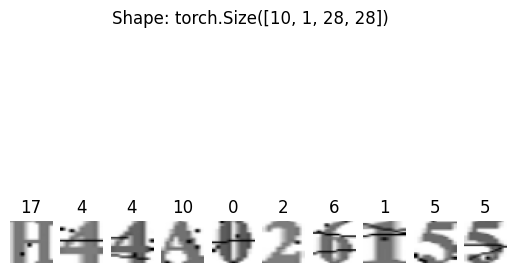

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, target):
    n = len(img)
    fig, ax = plt.subplots(1, n)
    fig.suptitle(f"Shape: {img.size()}")
    images = np.split(img.numpy(), n)
    for i in range(n):
        ax[i].imshow(np.squeeze(images[i]), cmap='gray')
        ax[i].set_title(str(target[i].item()))
        ax[i].axis('off')
    plt.show()

# show images
imshow(inputs, labels)

Feature batch shape: torch.Size([10, 1, 28, 28])
Labels batch shape: torch.Size([10])


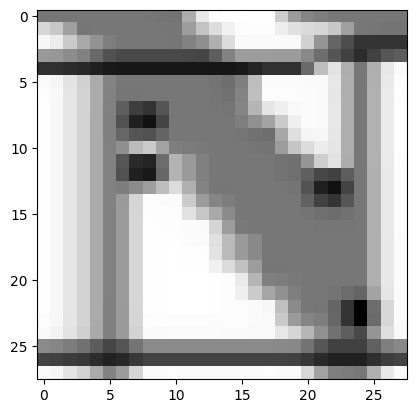

Label: 23


In [22]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {label}")

# CNN

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 36)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=36, bias=True)
)


# train 1

Epoch 1/20: Training loss = 3.262393761903812
Epoch 2/20: Training loss = 2.8270969879932895
Epoch 3/20: Training loss = 1.5593666992126367
Epoch 4/20: Training loss = 0.8559875707022655
Epoch 5/20: Training loss = 0.5976613735159239
Epoch 6/20: Training loss = 0.4842548487851253
Epoch 7/20: Training loss = 0.3882474252627267
Epoch 8/20: Training loss = 0.31596638489132506
Epoch 9/20: Training loss = 0.2706178236209477
Epoch 10/20: Training loss = 0.18601910957994944
Epoch 11/20: Training loss = 0.15725722704202127
Epoch 12/20: Training loss = 0.14051053961977744
Epoch 13/20: Training loss = 0.15018498310401368
Epoch 14/20: Training loss = 0.1105496542967068
Epoch 15/20: Training loss = 0.1276354593500377
Epoch 16/20: Training loss = 0.08972028533641535
Epoch 17/20: Training loss = 0.11438342774654768
Epoch 18/20: Training loss = 0.1091835008134158
Epoch 19/20: Training loss = 0.11141491991778214
Epoch 20/20: Training loss = 0.11627381239743091


Text(0, 0.5, 'Training loss')

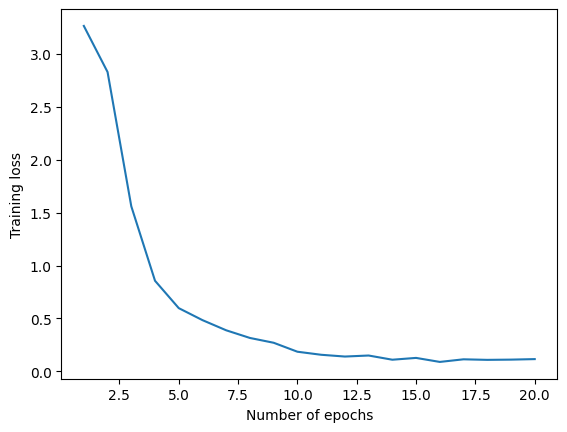

In [25]:
model = net

#Defining the model hyper parameters
num_epochs = 20
learning_rate = 0.001
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Training process begins
train_loss_list = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0
	
	#Iterating over the training dataset in batches
	model.train()
	for i, (images, labels) in enumerate(train_loader):
		
		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = model(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()
		
	
	#Printing loss for each epoch
	train_loss_list.append(train_loss/len(train_loader))
	print(f"Training loss = {train_loss_list[-1]}")
	
#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


# acc

In [26]:
nomi = {v:k for k, v in numer.items()}
print(nomi)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [28]:
test_acc=0
model.eval()

with torch.no_grad():
	#Iterating over the training dataset in batches
	for i, (images, labels) in enumerate(test_set):
		
		images = images.to(device)
		img = images.squeeze()
		images = images.unsqueeze(0)
		# print(images.shape)
		y_true = labels
		
		#Calculating outputs for the batch being iterated
		outputs = model(images)
		
		#Calculated prediction labels from models
		_, y_pred = torch.max(outputs.data, 1)
		
		# plt.imshow(img, cmap='gray')
		# plt.title(f"pred: {nomi[y_pred.numpy()[0]]}")
		# plt.show()

		#Comparing predicted and true labels
		test_acc += (y_pred == y_true).sum().item()
	
	print(f"Test set accuracy = {100 * test_acc / len(test_set)} %")


Test set accuracy = 90.69767441860465 %


In [21]:
#Saving the model
torch.save(model.state_dict(), 'model.pth')